In [1]:
import numpy as np
from random import random, randint

from math import pi, sqrt, exp

twopi = 2 * pi

from scipy.signal import convolve2d

In [2]:
def make_gaussian_kernel(kernel_size, sigma=1): 
    x, y = np.meshgrid(np.linspace(-1, 1, kernel_size),
                       np.linspace(-1, 1, kernel_size))
    
    tss = 2 * sigma ** 2
    gk = np.exp(-(x ** 2 + y ** 2) / tss)
    return gk

def normalized_kernel(K):
    return K / np.sum(K)

def make_circular_gaussian(center, radius, sigma):
    x0, y0 = center
    tss = 2 * sigma ** 2
    r2 = radius ** 2
    SF = -1 / (tss * r2)
        
    def _circular_gaussian(x, y):
        return exp(SF * ((x - x0) ** 2 + (y - y0) ** 2))

    return _circular_gaussian

def make_bipolar_ihd(amplitude=1, RMS=None, n=1, rng=None):
    # Irwin-Hall distributed random variable, sum of n independent uniform variates
    
    if RMS is None:
        A = amplitude / n
    else:
        A = RMS * np.sqrt(12 / n)

    assert(not rng is None)
        
    def _bipolar_ihd():
        return A * (np.sum(rng.random(n)) - n / 2)
    
    return _bipolar_ihd

In [3]:
class HeightMap():
    def __init__(self, width, height, rng=None, seed=None):
        self.width  = width
        self.height = height
        self.center = ( (height - 1) / 2, (width - 1) / 2)
        self.radius = min(width, height) / 2
        self.array = np.zeros((height, width))
        
        if seed is None:
            seed = 314159265459
        if rng is None:
            rng = np.random.default_rng(seed)
        
        self.rng = rng
        
    def perturb(self, amplitude=1, center=None, sigma=1, ihdn=1, rng=None):
        if center is None:
            center = self.center
        x0, y0 = center
        
        if rng is None:
            rng = self.rng

        CG = make_circular_gaussian(center, self.radius, sigma)
        IHD = make_bipolar_ihd(amplitude, n=ihdn, rng=rng)
        
        y = 0
        for row in self.array:
            for x in range(self.width):
                row[x] += CG(x, y) * IHD()
            y += 1

    def smooth(self, kernel_size=None, sigma=None, n=None):
        if kernel_size is None:
            kernel_size = 1
        if sigma is None:
            sigma = 1
        if n is None:
            n = 1 
        
        if kernel_size > 1: # smoothing with a 1x1 kernel is a NOP
            GK = make_gaussian_kernel(kernel_size, sigma)
            NGK = normalized_kernel(GK)
            for i in range(n):
                self.array = convolve2d(self.array, NGK, mode="same", boundary="fill")


In [4]:
radius = 50
width, height = 2 * radius, 2 * radius

hm = HeightMap(width, height)
perturb_rng = np.random.default_rng(20231230)

amplitude = 1
sigma = 1

for k in range(1, 6):
    lrk = list(range(1, k+1))
    points = [ [ height * y / (k + 1), width * x / (k + 1) ] for y in lrk for x in lrk ]
    
    #print(k, amplitude, sigma)
    
    for p in points:
        hm.perturb(amplitude=amplitude, sigma=.2, center=p, ihdn=6, rng=perturb_rng)
        
    amplitude *= 0.9
    sigma *= 0.75
    
hm.smooth(kernel_size=13, sigma = 1)
hm.smooth(kernel_size=5, sigma = 0.2, n=3)

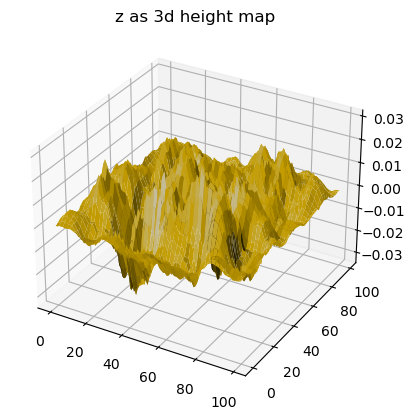

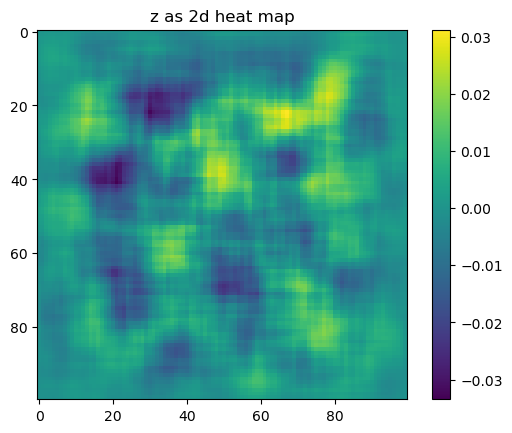

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

z = hm.array
x, y = np.meshgrid(range(z.shape[0]), range(z.shape[1]))

# show hight map in 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

yellow = np.array([1, 0.8, 0])
rgb = np.tile(yellow, (z.shape[0], z.shape[1], 1))

ls = LightSource()
illuminated_surface = ls.shade_rgb(rgb, z)

ax.plot_surface(x, y, z,
                linewidth=0,
                antialiased=True,
                facecolors=illuminated_surface)

#ax.plot_surface(x, y, z, rstride=1, cstride=1, shade=True, lightsource=LightSource)
plt.title('z as 3d height map')
plt.show()

# show height map in 2d
plt.figure()
plt.title('z as 2d heat map')
p = plt.imshow(z)
plt.colorbar(p)
plt.show()